In [44]:
import pandas as pd
from pathlib import Path

# Define the data directory
data_dir = Path('../data')

# Load METASPACE annotation files
hmdb_annotations = pd.read_csv(data_dir / '/home/parsa/PycharmProjects/HT-SpaceM/maldi_data/HMDB Metaspace_annotations.csv', sep=',',  comment='#', quotechar='"')
lipidmaps_annotations = pd.read_csv(data_dir / '/home/parsa/PycharmProjects/HT-SpaceM/maldi_data/Lipidmaps Metaspace_annotations.csv', sep=',',  comment='#', quotechar='"')


In [45]:
# Add a 'Source' column to each DataFrame
lipidmaps_annotations['Source'] = 'Lipidmaps'
hmdb_annotations['Source'] = 'HMDB'

# Combine the DataFrames
combined_df = pd.concat([lipidmaps_annotations, hmdb_annotations], ignore_index=True)

# Ensure 'fdr' is of type float
combined_df['fdr'] = combined_df['fdr'].astype(float)


In [46]:
# Count occurrences of each FDR value
fdr_counts = combined_df.groupby(['datasetId', 'Source', 'fdr']).size().unstack(fill_value=0)

# Compute cumulative counts
fdr_counts['0.05'] = fdr_counts.get(0.05, 0)
fdr_counts['0.1'] = fdr_counts['0.05'] + fdr_counts.get(0.1, 0)
fdr_counts['0.2'] = fdr_counts['0.1'] + fdr_counts.get(0.2, 0)
fdr_counts['0.5'] = fdr_counts['0.2'] + fdr_counts.get(0.5, 0)

# Reset index for plotting
fdr_counts = fdr_counts.reset_index()


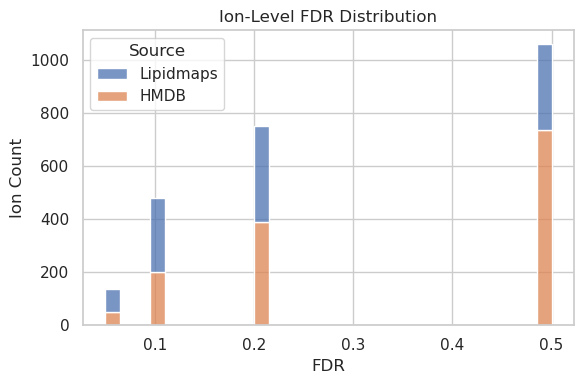

In [50]:
filtered = combined_df[combined_df['fdr'] <= 0.5]

# Plot
plt.figure(figsize=(6, 4))
sns.histplot(data=filtered, x='fdr', hue='Source', bins=30, multiple='stack')
plt.title('Ion-Level FDR Distribution')
plt.xlabel('FDR')
plt.ylabel('Ion Count')
plt.tight_layout()
plt.show()

In [18]:
*# Define FDR threshold
fdr_threshold = 0.1

# Filter annotations
hmdb_filtered = hmdb_annotations[hmdb_annotations['fdr'] <= fdr_threshold]
lipidmaps_filtered = lipidmaps_annotations[lipidmaps_annotations['fdr'] <= fdr_threshold]


In [ ]:
# FDR values downloaded from METASPACE project 'Delafiori et al. (2024)'
FDR = pd.read_csv(FDR_path)
FDR = FDR.astype(str).groupby(['datasetKey', 'CellLine', 'fdr'])['fdr'].count().unstack().fillna(0).astype(int)
FDR.columns.name = None

#ccomputing cumulative FDR
FDR['0.1'] = FDR['0.05'] + FDR['0.1']
FDR['0.2'] = FDR['0.1'] + FDR['0.2']
FDR['0.5'] = FDR['0.2'] + FDR['0.5']

In [22]:
#input
import seaborn as sns
import scanpy as sc

data_dir = Path(r'../data')
anndata_path = data_dir / 'hfd_4_preprocessed.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_2'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

In [23]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata.raw = adata

In [30]:
adata.obs

,x,y,z,n_genes
px_0,8,1,1,477
px_1,9,1,1,523
px_2,10,1,1,502
px_3,11,1,1,500
px_4,12,1,1,553
...,...,...,...,...
px_8953,66,93,1,535
px_8954,67,93,1,568
px_8955,68,93,1,579
px_8956,69,93,1,543


In [32]:
cell_qc, ion_qc = sc.pp.calculate_qc_metrics(adata, percent_top=[135])
# the condition column should be in adata.obs
condition_column = 'n_genes'
# qc table and adata.obs should have the same index
cell_qc_joined = pd.merge(adata.obs[[condition_column]], cell_qc, left_index=True, right_index=True)

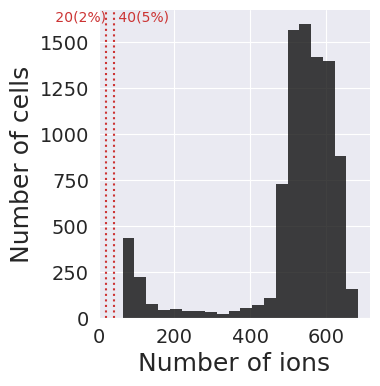

In [34]:

import matplotlib.pyplot as plt

# calculate the cutoff percentage of ions present in each cell
min_ions1 = 20
min_ions2 = 40
percent_ions1 = min_ions1 / len(adata.var_names)
percent_ions2 = min_ions2 / len(adata.var_names)

plt.figure(figsize=(3.5, 4))
ax = sns.histplot(data=cell_qc_joined,
                  x='n_genes_by_counts',
                  bins=20,
                  linewidth=0,
                  color='black',
                  multiple='stack')

ax.set_xlabel('Number of ions', fontsize=18)
ax.set_ylabel('Number of cells', fontsize=18)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(left=0)
sns.despine(offset=0, trim=False, ax=ax)
sns.despine(trim=False, ax=ax)

# printing the cutoff as a vertical line with relative and absolute cutoff values
ax.axvline(x=min_ions1, linestyle=':', c='#CC3333')
ax.text(x=min_ions1, y=ax.get_ylim()[1], s=f' {min_ions1}({percent_ions1:.0%})',
        fontsize=10, va='top', ha='right', color='#CC3333')
ax.axvline(x=min_ions2, linestyle=':', c='#CC3333')
ax.text(x=min_ions2, y=ax.get_ylim()[1], s=f' {min_ions2}({percent_ions2:.0%})',
        fontsize = 10, va='top', ha='left', color='#CC3333')

plt.savefig(plots_path / 'panel_C.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_C.svg', bbox_inches='tight')